# Source localization problem
You are given a square domain in which there are placed sensors. An impulse source is placed in the domain and fires at $T_{trigger}$. Each sensor registers the time it has received the impulse. Find the position of the source, if the propagation dynamic is:

$$ T_i = T_{trigger} + \sqrt{(\frac{x - x_i}{v_x})^2 + (\frac{y - y_i}{v_y})^2} $$

where $(x,y)$ is the position of the source

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

## Problem definition

### Sensor positions

In [2]:
L = 2.0

SENSOR_LOCATIONS = np.array([
    [3.42658477, 2.46352549],
    [3.23637347, 2.40172209],
    [2.66573956, 2.2163119 ],
    [2.47552826, 2.1545085 ],
    [2.        , 3.5       ],
    [2.        , 3.3       ],
    [2.        , 2.7       ],
    [2.        , 2.5       ],
    [0.57341523, 2.46352549],
    [0.76362653, 2.40172209],
    [1.33426044, 2.2163119 ],
    [1.52447174, 2.1545085 ],
    [1.11832212, 0.78647451],
    [1.23587917, 0.94827791],
    [1.58855032, 1.4336881 ],
    [1.70610737, 1.5954915 ],
    [2.88167788, 0.78647451],
    [2.76412083, 0.94827791],
    [2.41144968, 1.4336881 ],
    [2.29389263, 1.595491  ],
]) - 2.0

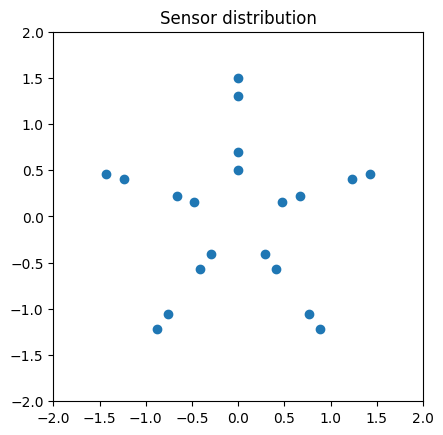

In [3]:
plt.title("Sensor distribution")
plt.scatter(
    SENSOR_LOCATIONS[:,0],
    SENSOR_LOCATIONS[:,1],
    label="sensors",
)
plt.xlim((-L,L))
plt.ylim((-L,L))
plt.gca().set_aspect('equal')
plt.show()

### Propagation dynamics

In [4]:
# from original problem
conduction_velocity = 80.0
a_ratio = 5.0

T_TRIGGER = 0.0
VELOCITY = conduction_velocity / np.array([1, a_ratio])

def compute_arrival_time(sensor_locations, velocity, trigger_time, source_location):
    return trigger_time + np.linalg.norm(
        (source_location - sensor_locations) / velocity,
        axis=1
    )

### Instance generation

In [5]:
class SingleSourceProblem:
    def __init__(
        self,
        trigger_time:     float,
        velocity:         np.ndarray,
        source_location:  np.ndarray,
        sensor_locations: np.ndarray,
        arrival_times:    np.ndarray,
        perturbation:     np.ndarray):

        self.trigger_time = trigger_time
        self.velocity = velocity
        self.source_location = source_location
        self.sensor_locations = sensor_locations
        self.arrival_times = arrival_times
        self.perturbation = perturbation

    def get_small_problem(self, n: int) -> 'SingleSourceProblem':
        assert(0 < n <= self.arrival_times.shape[0])

        idx = np.random.choice(
            self.arrival_times.shape[0],
            size=n,
            replace=False,
        )

        return SingleSourceProblem(
            self.trigger_time,
            self.velocity,
            self.source_location,
            self.sensor_locations[idx],
            self.arrival_times[idx],
            self.perturbation[idx],
        )

    def __repr__(self):
        return f"""SingleSourceProblem(
    trigger_time     = {type(self.trigger_time)},
    velocity         = {type(self.velocity)},
    source_location  = {type(self.source_location)},
    sensor_locations = {type(self.sensor_locations)},
    arrival_times    = {type(self.arrival_times)},
    perturbation     = {type(self.perturbation)},
)"""

In [6]:
def generate_problem_instance(outliers: int = 0, sigma: float = 0.0) -> SingleSourceProblem:
    n = SENSOR_LOCATIONS.shape[0]

    trigger_time = T_TRIGGER
    source_location = np.array(np.random.uniform(-L, L, size=2))

    arrival_times = compute_arrival_time(
        SENSOR_LOCATIONS,
        VELOCITY,
        trigger_time,
        source_location
    )

    perturbation = np.zeros(n)
    perturbation[np.random.choice(n, outliers, replace=False)] = np.random.normal(0.0, sigma, size=outliers)

    return SingleSourceProblem(
        trigger_time,
        VELOCITY,
        source_location,
        SENSOR_LOCATIONS,
        arrival_times + perturbation,
        perturbation
    )

problem = generate_problem_instance()

### Visualization

In [7]:
def compute_activation_field(problem: SingleSourceProblem, mesh):
    xx, yy = np.meshgrid(mesh, mesh)

    return compute_arrival_time(
        np.array([xx.flatten(), yy.flatten()]).T,
        problem.velocity,
        problem.trigger_time,
        problem.source_location
    ).reshape(xx.shape)

In [8]:
def plot_problem(problem: SingleSourceProblem, resolution = 128):
    mesh = np.linspace(-L, L, num=resolution)
    T = compute_activation_field(problem, mesh)

    plt.pcolormesh(mesh, mesh, T)
    plt.colorbar()
    
    plt.scatter(
        problem.sensor_locations[:,0],
        problem.sensor_locations[:,1],
        marker='o',
        color='w',
        label='sensors'
    )
    plt.scatter(
        problem.source_location[0],
        problem.source_location[1],
        marker='x',
        color='r',
        label='source'
    )

    plt.xlim((-L,L))
    plt.ylim((-L,L))
    plt.title("Arrival time field")
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()

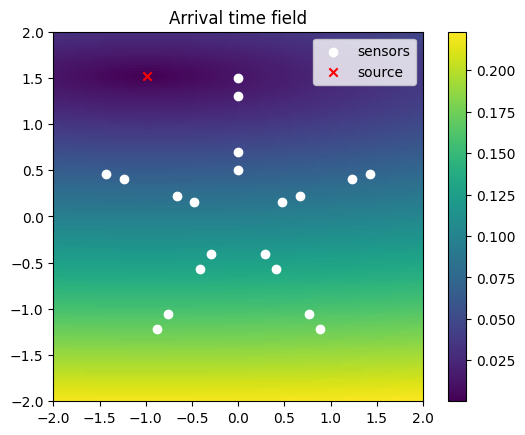

In [9]:
plot_problem(problem)

# Optimization
The solution of the problem satisfy simultaneously all the sensor constraints. Since there may be errors, we say that the solution satisfy the non linear system in a **least squares** sense.

Selecting an appropriate loss function is critical in the presence of outliers (the goal of this notebook). In that case, alternative loss functions like Cauchy attenuate the contribution of the outliers.

$$ \mathcal{L}(x, y) = \frac{1}{N} \sum_{i=1}^{N} \rho(T_i - \sqrt{(\frac{x - x_i}{v_x})^2 + (\frac{y - y_i}{v_y})^2}) $$

In [10]:
test_problem = generate_problem_instance()

In [11]:
def residual(problem: SingleSourceProblem, x) -> np.ndarray:
    return problem.arrival_times - compute_arrival_time(
        problem.sensor_locations, problem.velocity, problem.trigger_time, x
    )

residual(test_problem, np.array([0.0, 0.0]))

array([ 0.04403854,  0.05212726,  0.07690899,  0.08530831, -0.07929589,
       -0.05519542,  0.01920714,  0.04413914,  0.04725129,  0.05480142,
        0.07818745,  0.08618704,  0.10640703,  0.10641785,  0.10645964,
        0.10647788,  0.10554084,  0.10562287,  0.10593968,  0.10607791])

In [12]:
def jacobian(problem: SingleSourceProblem, x) -> np.ndarray:
    diffs = (x - problem.sensor_locations) / problem.velocity

    return -diffs / (np.linalg.norm(diffs, axis=1, keepdims=True) * problem.velocity)

jacobian(test_problem, np.array([0.0, 0.0]))

array([[ 0.00655239,  0.05322503],
       [ 0.00655239,  0.05322503],
       [ 0.00655239,  0.05322503],
       [ 0.00655239,  0.05322503],
       [-0.        ,  0.0625    ],
       [-0.        ,  0.0625    ],
       [-0.        ,  0.0625    ],
       [-0.        ,  0.0625    ],
       [-0.00655239,  0.05322503],
       [-0.00655239,  0.05322503],
       [-0.00655239,  0.05322503],
       [-0.00655239,  0.05322503],
       [-0.00179748, -0.06185044],
       [-0.00179748, -0.06185044],
       [-0.00179748, -0.06185044],
       [-0.00179748, -0.06185044],
       [ 0.00179748, -0.06185044],
       [ 0.00179748, -0.06185044],
       [ 0.00179748, -0.06185044],
       [ 0.00179748, -0.06185044]])

### Loss interface

In [13]:
class AbstractLoss:
    def __call__(self, residuals: np.ndarray) -> float:
        raise NotImplementedError()

    def __str__(self):
        raise NotImplementedError()
    

class SquaredLoss(AbstractLoss):
    def __call__(self, residuals: np.ndarray) -> float:
        return 0.5 * np.dot(residuals, residuals)

    def __str__(self):
        return "SquaredLoss()"


class HuberLoss(AbstractLoss):
    def __init__(self, delta: float):
        self.delta = delta

    def __call__(self, residuals: np.ndarray) -> float:
        abs_r = np.abs(residuals)
        quadratic = np.minimum(abs_r, self.delta)
        linear = abs_r - quadratic

        return np.sum(0.5 * np.dot(quadratic, quadratic) + self.delta * linear)

    def __str__(self):
        return f"HuberLoss({self.delta})"
    

class CauchyLoss(AbstractLoss):
    def __init__(self, c: float = 1.0):
        self.c = c

    def __call__(self, residuals: np.ndarray) -> float:
        return np.sum(self.c**2 / 2 * np.log1p((residuals / self.c)**2))

    def __str__(self):
        return "CauchyLoss()"


class ArctanLoss(AbstractLoss):
    def __init__(self, c: float = 1.0):
        self.c = c

    def __call__(self, residuals: np.ndarray) -> float:
        return np.sum(self.c**2 * np.arctan((residuals / self.c)**2))

    def __str__(self):
        return "ArctanLoss()"


### Solver interface

In [14]:
# unified solver interface for both scipy and custom solvers
class AbstractSolver:
    def __init__(self):
        pass

    def solve(self, problem: SingleSourceProblem, x0):
        raise NotImplemented

    def __str__(self):
        raise NotImplemented

In [15]:
class LeastSquaresSolver(AbstractSolver):
    # loss is one of:
    #   * linear
    #   * soft_l1
    #   * huber
    #   * cauchy
    #   * arctan
    def __init__(self, loss: str = 'linear', gtol: float = 1e-8):
        self.loss = loss
        self.gtol = gtol

    def solve(self, problem: SingleSourceProblem, x0):
        return opt.least_squares(
            lambda x: np.array(residual(problem, x)),
            x0,
            loss=self.loss,
            jac=lambda x: jacobian(problem, x),
            gtol=self.gtol,
        )
    
    def __str__(self):
        return f'LSQ({self.loss}, gtol={self.gtol})'


optimize_result = LeastSquaresSolver().solve(problem, np.array([0.0, 0.0]))
optimize_result

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.130e-12 -1.131e-12 ... -1.094e-12 -1.094e-12]
           x: [-9.876e-01  1.523e+00]
        cost: 1.1316149366847916e-23
         jac: [[ 5.184e-03 -5.687e-02]
               [ 4.610e-03 -5.809e-02]
               ...
               [ 1.659e-03 -6.195e-02]
               [ 1.648e-03 -6.195e-02]]
        grad: [-4.831e-14  1.253e-12]
  optimality: 1.2525728495756331e-12
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 7
        njev: 7

In [16]:
class MinimizeSolver(AbstractSolver):
    def __init__(self, loss: AbstractLoss = SquaredLoss()):
        self.loss = loss

    def solve(self, problem: SingleSourceProblem, x0):
        optimize_result = opt.minimize(
            fun=lambda x: self.loss(residual(problem, x)),
            x0=x0,
            jac=lambda x: jacobian(problem, x).T @ residual(problem, x),
        )

        assert(optimize_result.success)

        return optimize_result
    
    def __str__(self):
        return f'MNMZ({self.loss})'


MinimizeSolver().solve(problem, np.array([0.0, 0.0]))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.904159861144987e-10
        x: [-9.895e-01  1.523e+00]
      nit: 12
      jac: [-6.882e-07  7.032e-06]
 hess_inv: [[ 3.770e+03  1.236e+02]
            [ 1.236e+02  1.789e+01]]
     nfev: 22
     njev: 22

I think this problem is ill conditioned as the residuals are very small (and also the jacobian), but the error is not so small. I'll need to study the Hessian matrix at the optimal point.

## Optimization in the presence of outliers
By injecting an error on a random sensor, the loss function changes (and so the optimal point)

A simple simulation shows the effect on the solution error as a function of the injected error. The choice of the loss function is critical for being robust to outliers

In [17]:
def sample_solver_robustness(nruns_per_bin: int, sigmas, outliers, solver: AbstractSolver):
    errors = np.zeros(len(sigmas))
    acc = np.zeros(nruns_per_bin)

    for (i, sigma) in enumerate(sigmas):
        for j in range(nruns_per_bin):
            perturbed_problem = generate_problem_instance(
                outliers,
                sigma,
            )

            expected_source_location = solver.solve(
                perturbed_problem,
                x0=np.zeros(2)
            ).x

            err = expected_source_location - perturbed_problem.source_location
            acc[j] = np.linalg.norm(err)

        errors[i] = np.mean(acc)

    return errors

In [18]:
def test_solver_robustness(nruns_per_bin: int, sigmas, outliers, solvers: list[AbstractSolver]):
    for solver in solvers:
        errors = sample_solver_robustness(
            nruns_per_bin,
            sigmas,
            outliers,
            solver
        )
        
        plt.loglog(sigmas, errors, marker='o', label=str(solver))

    plt.xlabel('$\\sigma$')
    plt.ylabel('abs err')
    plt.title(f"Solver robustness for {outliers}/{SENSOR_LOCATIONS.shape[0]} outliers")
    plt.legend()
    plt.show()

### Least squares solvers
The following test are done on variations of the `scipy.optimize.least_squares` routine.

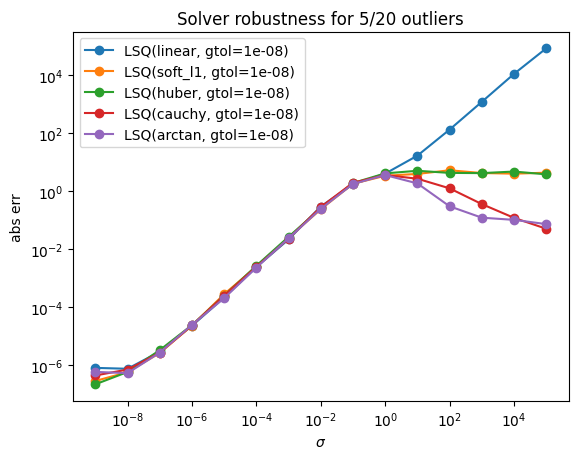

In [19]:
test_solver_robustness(
    nruns_per_bin=200,
    sigmas=10.0**np.arange(-9,6),
    outliers=5,
    solvers=[
        LeastSquaresSolver('linear'),
        LeastSquaresSolver('soft_l1'),
        LeastSquaresSolver('huber'),
        LeastSquaresSolver('cauchy'),
        LeastSquaresSolver('arctan'),
    ]
)

## Using "robust" optimizers
I'm interested in improving the error bounds for the least squares optimizers. This problem is hard because an optimizer is only good as its loss (*).

As changing the loss has effect on the final error, the next step is removing the outlier contributions to the loss. I found experimentally that the residuals after the first optimization pass are estimators (qualitative) of the perturbation injected in the arrival times.

Residuals are clustered around the origin, except for outliers. The quality of the outlier detection method will affect the final error. I provide a lower bound for the error by implementing a solver that has 100% accuracy on outlier detection.

In [25]:
def sample_small_problem_optimization(
    nruns_per_bin: int,
    sensor_sizes: list[int],
    solver: AbstractSolver,
    shitty_problems : list[SingleSourceProblem]= None):

    errors = np.zeros(len(sensor_sizes))

    for (i, sensor_size) in enumerate(sensor_sizes):
        local_errors = np.zeros(nruns_per_bin)

        for j in range(nruns_per_bin):
            original_problem = generate_problem_instance()
            small_problem = original_problem.get_small_problem(sensor_size)

            optimize_result = solver.solve(
                small_problem,
                x0=np.zeros(2)
            )

            assert(optimize_result.success)

            expected_source_location = optimize_result.x
            err = np.linalg.norm(expected_source_location - small_problem.source_location)

            print(err)

            if err > 1e-2 and shitty_problems is not None:
                shitty_problems.append(small_problem)

            local_errors[j] = err

        errors[i] = np.median(local_errors)

    return errors

In [26]:
def test_small_problem_optimization(
    nruns_per_bin: int,
    sensor_sizes: list[int],
    solvers: list[AbstractSolver],
    shitty_problems : list[SingleSourceProblem] = None):

    for solver in solvers:
        errors = sample_small_problem_optimization(
            nruns_per_bin,
            sensor_sizes,
            solver,
            shitty_problems
        )
        
        plt.semilogy(sensor_sizes, errors, marker='o', label=str(solver))

    plt.xticks(sensor_sizes)
    plt.xlabel('# sensors')
    plt.ylabel('avg $|| x - x_{opt} ||$')
    plt.title("Errors when solving smaller problems")
    plt.legend()
    plt.show()

1.507166987491572e-09
6.727942934154773e-11
4.092596745122188e-08
8.14048931100971e-09
5.248515758719431e-10
5.347649647080501e-07
1.4335316727837086e-07
6.730735091546908
2.250224542180391e-07
2.4195472355584494e-07
1.1296813634198764e-05
4.689295972359946e-11
3.0709784891319145e-06
5.662480874972881e-07
1.849042657442049e-10
1.9500480558016922
9.942586506800233e-07
2.0134282289102706e-11
2.2341016673999303e-08
9.351535014103513e-10
3.134560041830653e-08
4.179860992665265e-07
9.16711545324011e-07
2.3053607886755921e-07
3.904432356776595e-06
2.5434688541751227e-12
3.4273374429818605e-10
3.0567631638051065
8.634097262313965e-07
3.0689063337500873e-07
3.2992950696384364e-06
2.431512676141293e-08
6.514561563383736e-07
2.5371479946768916
6.669872223007621
2.152411963063613e-09
1.6182666381024386e-06
5.7658266377180224e-05
1.4706011116918902e-10
1.8529461076429301e-06
6.1530969077534385e-09
2.44063127839591e-08
0.49684464265666556
1.344763208495189e-05
9.775790672506616e-06
2.56851560055730

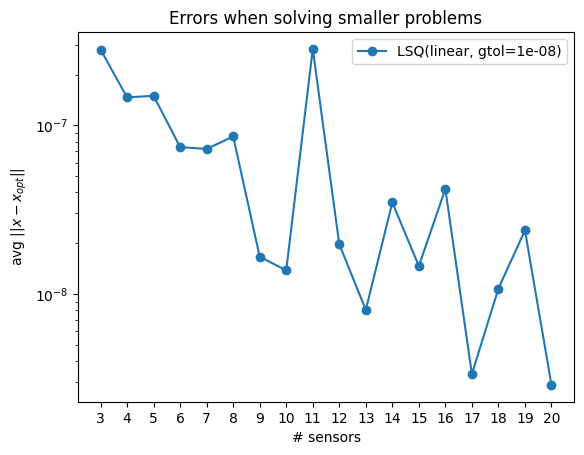

In [27]:
shitty_problems = []

test_small_problem_optimization(
    nruns_per_bin=50,
    sensor_sizes=np.arange(3, SENSOR_LOCATIONS.shape[0]+1),
    solvers=[
        LeastSquaresSolver(),
    ],
    shitty_problems=shitty_problems
)

I really don't like this plot. I hope there is a problem in the optimization procedure otherwise this source location problem is very ill-conditioned.

Here is a possible explanation of the phenomena, excluding implementation bugs. The problem is ill conditioned, so even with small residuals the solution is far from the optimal point. The residuals alone don't give a complete idea of what's going on. I suspect all the iterations are stopped by the `gtol` condition

### Explaining why the optimizer suck

In [24]:
LeastSquaresSolver().solve(shitty_problems[0], np.zeros(2))

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-5.312e-03  4.113e-03 -2.159e-03]
           x: [-5.761e-01 -5.915e-01]
        cost: 2.4899754937305906e-05
         jac: [[ 4.436e-03  5.843e-02]
               [ 8.514e-03  4.576e-02]
               [ 5.305e-03 -5.659e-02]]
        grad: [-2.772e-10  2.432e-09]
  optimality: 2.432184191758979e-09
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 10
        njev: 10

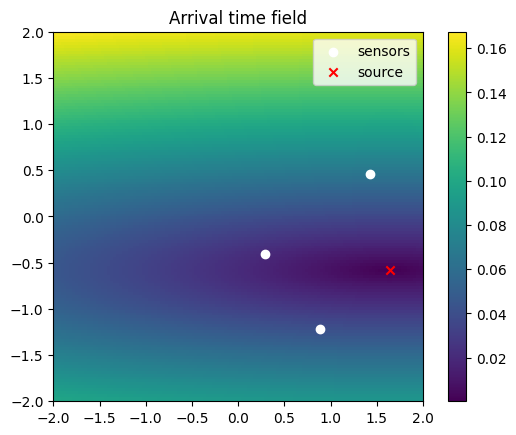

In [23]:
plot_problem(shitty_problems[0])